In [1]:
import os
import polars as pl

In [2]:
test_path = os.path.join(os.getenv("HOME"), "higgs", "test.parquet")
train_path = os.path.join(os.getenv("HOME"), "higgs", "train.parquet")

In [3]:
os.path.exists(test_path), os.path.exists(train_path)

(True, True)

In [4]:
train_df, test_df = pl.read_parquet(train_path), pl.read_parquet(test_path)

In [5]:
data_col_count = 28
data_cols = [str(col + 1) for col in range(data_col_count)]

In [6]:
import torch
torch.manual_seed(6996)

In [7]:
target_count = 2

In [8]:
model = torch.nn.Sequential(
    torch.nn.Linear(
        in_features = data_col_count,
        out_features = 128,
    ),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(
        in_features = 128,
        out_features = data_col_count,
    ),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(
        in_features = data_col_count,
        out_features = data_col_count // 2,
    ),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(
        in_features = data_col_count // 2,
        out_features = data_col_count // 4,
    ),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(
        in_features = data_col_count // 4,
        out_features = target_count,
    ),
    torch.nn.Sigmoid(),
)

model

Sequential(
  (0): Linear(in_features=28, out_features=128, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=128, out_features=28, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=28, out_features=14, bias=True)
  (5): LeakyReLU(negative_slope=0.01)
  (6): Linear(in_features=14, out_features=7, bias=True)
  (7): LeakyReLU(negative_slope=0.01)
  (8): Linear(in_features=7, out_features=2, bias=True)
  (9): Sigmoid()
)

In [9]:
class HiggsDataset(torch.utils.data.Dataset):
    def __init__(self, df):
        self.data_s = df["label"]
        self.label_df = df[data_cols]
    def __len__(self) -> int:
        return len(self.data_s)
    def __getitem__(self, index):
        y = self.data_s.item(index)
        x = self.label_df.row(index)
        xt = torch.asarray(x).to(torch.float32)
        yt = torch.zeros(size = (target_count,), dtype = torch.float32)
        yt.index_fill_(dim = 0, index = torch.asarray(y).to(torch.int64), value = 1.0)
        return (xt, yt)

In [10]:
train_ds = HiggsDataset(df = train_df)
train_ds[16]

(tensor([ 1.4842,  1.6995, -1.0595,  2.7002, -1.0560,  2.4095,  0.4575,  0.3450,
         -1.0000,  1.4149,  1.1142, -1.4489, -1.0000,  1.0130, -2.0570,  1.1310,
         -1.0000,  0.9055,  2.1824,  1.0431, -1.0000,  1.6536,  0.9936,  0.9833,
          0.7414,  0.1634,  0.5923,  0.7451]),
 tensor([0., 1.]))

In [11]:
gen = torch.Generator(device = "cpu")
gen.manual_seed(6969)
train_dl = torch.utils.data.DataLoader(
    dataset = train_ds, 
    batch_size = 25_000, 
    shuffle = True, 
    pin_memory = True, 
    num_workers = 4, 
    generator = gen,
)

In [12]:
from tqdm import tqdm

In [13]:
import rootutils
path = rootutils.find_root(search_from = os.getcwd(), indicator = ".project-root")
rootutils.set_root(path = path, project_root_env_var = True, dotenv = True, pythonpath = True, cwd = True,)

In [14]:
from fourier.integration import integrate
from fourier.roc_auc_loss import RocAucLoss
from fourier.compute_fourier import compute_fourier
from fourier.evaluate_fourier import evaluate_fourier
from fourier.custom_typing import DeviceLike, FPTensor
from fourier.fourier import normalize_by_samples, SinCos, DEFAULT_FACTOR

In [15]:
rocauc_loss = RocAucLoss(n_harmonics = 128, n_steps = 4_096).cuda()

In [16]:
bce_loss = torch.nn.BCELoss().cuda()

In [17]:
fourier_values, bce_values = [], []

model_train = model.cuda().train().cuda()
optimizer = torch.optim.Adam(model_train.parameters(), lr = 1e-4)
for i in tqdm(range(5)):
    for j, (x, y) in enumerate(tqdm(train_dl)):
        optimizer.zero_grad()
        result = model_train.forward(x.cuda())
        y_float = y.cuda()
        y_bool = y_float.to(torch.bool)
        bce_loss_value = bce_loss(result, y_float)
        rocauc_loss_value = rocauc_loss(result, y_bool)
        loss_value = 1.0 - 1.0 * rocauc_loss_value + 0.5 * bce_loss_value
        if j % 10 == 0:
            fourier_values.append(rocauc_loss_value.detach().cpu().item())
            bce_values.append(bce_loss_value.detach().cpu().item())
            print("\tFourier:", fourier_values[-1])
            print("\tBCE:", bce_values[-1])
        loss_value.backward()
        optimizer.step()
        optimizer.zero_grad()
model = model_train.cpu().eval().cpu()

  0%|                                                                                           | 0/400 [00:00<?, ?it/s]

	Fourier: 0.526009202003479
	BCE: 0.6954293847084045



  3%|██▎                                                                               | 11/400 [00:03<01:26,  4.50it/s]

	Fourier: 0.534150242805481
	BCE: 0.6945807933807373



  5%|████▎                                                                             | 21/400 [00:05<01:11,  5.29it/s]

	Fourier: 0.5335763096809387
	BCE: 0.6949782371520996



  8%|██████▎                                                                           | 31/400 [00:07<01:18,  4.71it/s]

	Fourier: 0.5335911512374878
	BCE: 0.6950113773345947



 10%|████████▍                                                                         | 41/400 [00:09<01:14,  4.82it/s]

	Fourier: 0.5395117998123169
	BCE: 0.6945667862892151



 13%|██████████▍                                                                       | 51/400 [00:12<01:15,  4.62it/s]

	Fourier: 0.5508415699005127
	BCE: 0.6933562159538269



 15%|████████████▌                                                                     | 61/400 [00:14<01:13,  4.58it/s]

	Fourier: 0.5455842614173889
	BCE: 0.6942336559295654



 18%|██████████████▌                                                                   | 71/400 [00:16<01:07,  4.86it/s]

	Fourier: 0.5518596172332764
	BCE: 0.6936310529708862



 20%|████████████████▌                                                                 | 81/400 [00:18<01:05,  4.87it/s]

	Fourier: 0.5535873174667358
	BCE: 0.693996250629425



 23%|██████████████████▋                                                               | 91/400 [00:20<01:02,  4.91it/s]

	Fourier: 0.5597254037857056
	BCE: 0.693579375743866



 25%|████████████████████▍                                                            | 101/400 [00:22<01:06,  4.49it/s]

	Fourier: 0.562105655670166
	BCE: 0.6937392950057983



 28%|██████████████████████▍                                                          | 111/400 [00:24<01:01,  4.71it/s]

	Fourier: 0.5689866542816162
	BCE: 0.6932631134986877



 30%|████████████████████████▌                                                        | 121/400 [00:26<00:57,  4.84it/s]

	Fourier: 0.5718473792076111
	BCE: 0.6936134099960327



 33%|██████████████████████████▌                                                      | 131/400 [00:28<00:59,  4.55it/s]

	Fourier: 0.5873887538909912
	BCE: 0.6922181248664856



 35%|████████████████████████████▌                                                    | 141/400 [00:30<00:51,  5.02it/s]

	Fourier: 0.590181827545166
	BCE: 0.6924107670783997



 38%|██████████████████████████████▌                                                  | 151/400 [00:32<00:45,  5.47it/s]

	Fourier: 0.5796961784362793
	BCE: 0.693852961063385



 40%|████████████████████████████████▌                                                | 161/400 [00:34<00:47,  4.99it/s]

	Fourier: 0.5974804759025574
	BCE: 0.6915682554244995



 43%|██████████████████████████████████▋                                              | 171/400 [00:36<00:43,  5.29it/s]

	Fourier: 0.5994699001312256
	BCE: 0.6915045380592346



 45%|████████████████████████████████████▋                                            | 181/400 [00:38<00:40,  5.47it/s]

	Fourier: 0.602949321269989
	BCE: 0.6910080909729004



 48%|██████████████████████████████████████▋                                          | 191/400 [00:40<00:39,  5.27it/s]

	Fourier: 0.6049206256866455
	BCE: 0.6910102963447571



 50%|████████████████████████████████████████▋                                        | 201/400 [00:42<00:34,  5.79it/s]

	Fourier: 0.603080153465271
	BCE: 0.6911531090736389



 53%|██████████████████████████████████████████▋                                      | 211/400 [00:44<00:35,  5.26it/s]

	Fourier: 0.6077439188957214
	BCE: 0.6905933618545532



 55%|████████████████████████████████████████████▊                                    | 221/400 [00:46<00:32,  5.53it/s]

	Fourier: 0.6067075133323669
	BCE: 0.6904714107513428



 58%|██████████████████████████████████████████████▊                                  | 231/400 [00:47<00:30,  5.49it/s]

	Fourier: 0.617428183555603
	BCE: 0.6892090439796448



 60%|████████████████████████████████████████████████▊                                | 241/400 [00:49<00:28,  5.55it/s]

	Fourier: 0.6191405653953552
	BCE: 0.6888582706451416



 63%|██████████████████████████████████████████████████▊                              | 251/400 [00:51<00:27,  5.39it/s]

	Fourier: 0.6098847389221191
	BCE: 0.6898473501205444



 65%|████████████████████████████████████████████████████▊                            | 261/400 [00:53<00:25,  5.55it/s]

	Fourier: 0.6126599907875061
	BCE: 0.6895790696144104



 68%|██████████████████████████████████████████████████████▉                          | 271/400 [00:55<00:24,  5.20it/s]

	Fourier: 0.6163578033447266
	BCE: 0.6888632774353027



 70%|████████████████████████████████████████████████████████▉                        | 281/400 [00:57<00:22,  5.27it/s]

	Fourier: 0.6196162700653076
	BCE: 0.688231885433197



 73%|██████████████████████████████████████████████████████████▉                      | 291/400 [00:58<00:19,  5.47it/s]

	Fourier: 0.6173784732818604
	BCE: 0.6883783936500549



 75%|████████████████████████████████████████████████████████████▉                    | 301/400 [01:00<00:17,  5.62it/s]

	Fourier: 0.6190468072891235
	BCE: 0.6884813904762268



 78%|██████████████████████████████████████████████████████████████▉                  | 311/400 [01:02<00:16,  5.40it/s]

	Fourier: 0.6135684251785278
	BCE: 0.6887938976287842



 80%|█████████████████████████████████████████████████████████████████                | 321/400 [01:04<00:14,  5.44it/s]

	Fourier: 0.6207727789878845
	BCE: 0.687716543674469



 83%|███████████████████████████████████████████████████████████████████              | 331/400 [01:06<00:12,  5.58it/s]

	Fourier: 0.6223635673522949
	BCE: 0.6876513957977295



 85%|█████████████████████████████████████████████████████████████████████            | 341/400 [01:08<00:11,  5.18it/s]

	Fourier: 0.6202256679534912
	BCE: 0.6875357031822205



 88%|███████████████████████████████████████████████████████████████████████          | 351/400 [01:09<00:09,  5.44it/s]

	Fourier: 0.6212103366851807
	BCE: 0.6872180104255676



 90%|█████████████████████████████████████████████████████████████████████████        | 361/400 [01:11<00:07,  5.46it/s]

	Fourier: 0.6247277855873108
	BCE: 0.686542272567749



 93%|███████████████████████████████████████████████████████████████████████████▏     | 371/400 [01:13<00:05,  5.39it/s]

	Fourier: 0.6241733431816101
	BCE: 0.6864604353904724



 95%|█████████████████████████████████████████████████████████████████████████████▏   | 381/400 [01:15<00:03,  5.16it/s]

	Fourier: 0.6250251531600952
	BCE: 0.6862431764602661



 98%|███████████████████████████████████████████████████████████████████████████████▏ | 391/400 [01:17<00:01,  5.40it/s]

	Fourier: 0.6234337091445923
	BCE: 0.6863577961921692



  0%|▏                                                                                  | 1/400 [00:01<08:00,  1.20s/it]

	Fourier: 0.6237524747848511
	BCE: 0.6859050393104553



  3%|██▎                                                                               | 11/400 [00:03<01:17,  5.03it/s]

	Fourier: 0.6250054836273193
	BCE: 0.6855382919311523



  5%|████▎                                                                             | 21/400 [00:05<01:08,  5.55it/s]

	Fourier: 0.623947024345398
	BCE: 0.6850621700286865



  8%|██████▎                                                                           | 31/400 [00:06<01:09,  5.35it/s]

	Fourier: 0.6362794637680054
	BCE: 0.684542179107666



 10%|████████▍                                                                         | 41/400 [00:08<01:03,  5.64it/s]

	Fourier: 0.6744699478149414
	BCE: 0.6852801442146301



 13%|██████████▍                                                                       | 51/400 [00:10<01:02,  5.62it/s]

	Fourier: 0.6796767711639404
	BCE: 0.6837741136550903



 15%|████████████▌                                                                     | 61/400 [00:12<01:00,  5.63it/s]

	Fourier: 0.6825779676437378
	BCE: 0.6831002831459045



 18%|██████████████▌                                                                   | 71/400 [00:14<01:01,  5.32it/s]

	Fourier: 0.6863583326339722
	BCE: 0.6828981041908264



 20%|████████████████▌                                                                 | 81/400 [00:16<00:58,  5.47it/s]

	Fourier: 0.6845752000808716
	BCE: 0.6829335689544678



 23%|██████████████████▋                                                               | 91/400 [00:17<00:55,  5.53it/s]

	Fourier: 0.6905657052993774
	BCE: 0.6826658248901367



 25%|████████████████████▍                                                            | 101/400 [00:19<00:56,  5.30it/s]

	Fourier: 0.6948986053466797
	BCE: 0.6824960708618164



 28%|██████████████████████▍                                                          | 111/400 [00:21<00:55,  5.22it/s]

	Fourier: 0.6916917562484741
	BCE: 0.6826537251472473



 30%|████████████████████████▌                                                        | 121/400 [00:23<00:51,  5.41it/s]

	Fourier: 0.690688967704773
	BCE: 0.6825043559074402



 33%|██████████████████████████▌                                                      | 131/400 [00:25<00:49,  5.43it/s]

	Fourier: 0.6964348554611206
	BCE: 0.6822717785835266



 35%|████████████████████████████▌                                                    | 141/400 [00:27<00:48,  5.31it/s]

	Fourier: 0.6978613138198853
	BCE: 0.6823273301124573



 38%|██████████████████████████████▌                                                  | 151/400 [00:29<00:48,  5.08it/s]

	Fourier: 0.6950325965881348
	BCE: 0.6823726296424866



 40%|████████████████████████████████▌                                                | 161/400 [00:31<00:49,  4.87it/s]

	Fourier: 0.6951081156730652
	BCE: 0.6823318004608154



 43%|██████████████████████████████████▋                                              | 171/400 [00:33<00:44,  5.13it/s]

	Fourier: 0.6945980787277222
	BCE: 0.6825131773948669



 45%|████████████████████████████████████▋                                            | 181/400 [00:35<00:42,  5.19it/s]

	Fourier: 0.6939799189567566
	BCE: 0.6823856234550476



 48%|██████████████████████████████████████▋                                          | 191/400 [00:36<00:39,  5.30it/s]

	Fourier: 0.696864128112793
	BCE: 0.6822413802146912



 50%|████████████████████████████████████████▋                                        | 201/400 [00:38<00:37,  5.33it/s]

	Fourier: 0.6980414390563965
	BCE: 0.6820541024208069



 53%|██████████████████████████████████████████▋                                      | 211/400 [00:40<00:33,  5.72it/s]

	Fourier: 0.7030136585235596
	BCE: 0.6815536022186279



 55%|████████████████████████████████████████████▊                                    | 221/400 [00:42<00:30,  5.87it/s]

	Fourier: 0.7062577605247498
	BCE: 0.6812893748283386



 58%|██████████████████████████████████████████████▊                                  | 231/400 [00:44<00:29,  5.70it/s]

	Fourier: 0.6995590329170227
	BCE: 0.6817492246627808



 60%|████████████████████████████████████████████████▊                                | 241/400 [00:46<00:30,  5.21it/s]

	Fourier: 0.6941899061203003
	BCE: 0.6820065975189209



 63%|██████████████████████████████████████████████████▊                              | 251/400 [00:47<00:29,  5.08it/s]

	Fourier: 0.6969949007034302
	BCE: 0.681718111038208



 65%|████████████████████████████████████████████████████▊                            | 261/400 [00:49<00:25,  5.55it/s]

	Fourier: 0.697655439376831
	BCE: 0.6816760897636414



 68%|██████████████████████████████████████████████████████▉                          | 271/400 [00:51<00:24,  5.28it/s]

	Fourier: 0.6912426352500916
	BCE: 0.6820758581161499



 70%|████████████████████████████████████████████████████████▉                        | 281/400 [00:53<00:21,  5.53it/s]

	Fourier: 0.7043437957763672
	BCE: 0.6809782385826111



 73%|██████████████████████████████████████████████████████████▉                      | 291/400 [00:55<00:20,  5.32it/s]

	Fourier: 0.7025096416473389
	BCE: 0.6810925006866455



 75%|████████████████████████████████████████████████████████████▉                    | 301/400 [00:57<00:17,  5.69it/s]

	Fourier: 0.7047273516654968
	BCE: 0.6806721687316895



 78%|██████████████████████████████████████████████████████████████▉                  | 311/400 [00:58<00:17,  5.09it/s]

	Fourier: 0.7075010538101196
	BCE: 0.6807616353034973



 80%|█████████████████████████████████████████████████████████████████                | 321/400 [01:00<00:14,  5.45it/s]

	Fourier: 0.6997635364532471
	BCE: 0.6810879707336426



 83%|███████████████████████████████████████████████████████████████████              | 331/400 [01:02<00:13,  5.10it/s]

	Fourier: 0.7011822462081909
	BCE: 0.6806694269180298



 85%|█████████████████████████████████████████████████████████████████████            | 341/400 [01:04<00:10,  5.57it/s]

	Fourier: 0.7038721442222595
	BCE: 0.6805296540260315



 88%|███████████████████████████████████████████████████████████████████████          | 351/400 [01:06<00:09,  5.28it/s]

	Fourier: 0.7002559900283813
	BCE: 0.6806988716125488



 90%|█████████████████████████████████████████████████████████████████████████        | 361/400 [01:07<00:06,  5.89it/s]

	Fourier: 0.7037760019302368
	BCE: 0.6804506182670593



 93%|███████████████████████████████████████████████████████████████████████████▏     | 371/400 [01:09<00:05,  5.43it/s]

	Fourier: 0.7025260329246521
	BCE: 0.6804409027099609



 95%|█████████████████████████████████████████████████████████████████████████████▏   | 381/400 [01:11<00:03,  5.29it/s]

	Fourier: 0.7023366093635559
	BCE: 0.680393636226654



 98%|███████████████████████████████████████████████████████████████████████████████▏ | 391/400 [01:13<00:01,  5.72it/s]

	Fourier: 0.7054428458213806
	BCE: 0.6801117658615112



  0%|▏                                                                                  | 1/400 [00:01<07:56,  1.19s/it]

	Fourier: 0.6985565423965454
	BCE: 0.6805588603019714



  3%|██▎                                                                               | 11/400 [00:03<01:18,  4.95it/s]

	Fourier: 0.7050315141677856
	BCE: 0.6801434755325317



  5%|████▎                                                                             | 21/400 [00:04<01:07,  5.62it/s]

	Fourier: 0.7100857496261597
	BCE: 0.679574191570282



  8%|██████▎                                                                           | 31/400 [00:06<01:10,  5.20it/s]

	Fourier: 0.7098114490509033
	BCE: 0.6797585487365723



 10%|████████▍                                                                         | 41/400 [00:08<01:03,  5.62it/s]

	Fourier: 0.7038819789886475
	BCE: 0.6800619959831238



 13%|██████████▍                                                                       | 51/400 [00:10<01:07,  5.15it/s]

	Fourier: 0.7060608863830566
	BCE: 0.6799176335334778



 15%|████████████▌                                                                     | 61/400 [00:12<01:06,  5.13it/s]

	Fourier: 0.7072091102600098
	BCE: 0.679516077041626



 18%|██████████████▌                                                                   | 71/400 [00:14<01:02,  5.23it/s]

	Fourier: 0.7038004398345947
	BCE: 0.6795881986618042



 20%|████████████████▌                                                                 | 81/400 [00:16<01:03,  5.01it/s]

	Fourier: 0.7059907913208008
	BCE: 0.6796548366546631



 23%|██████████████████▋                                                               | 91/400 [00:18<01:00,  5.14it/s]

	Fourier: 0.7022921442985535
	BCE: 0.6796644330024719



 25%|████████████████████▍                                                            | 101/400 [00:19<00:52,  5.66it/s]

	Fourier: 0.7119698524475098
	BCE: 0.678899347782135



 28%|██████████████████████▍                                                          | 111/400 [00:21<00:53,  5.41it/s]

	Fourier: 0.7051984071731567
	BCE: 0.679294228553772



 30%|████████████████████████▌                                                        | 121/400 [00:23<00:49,  5.68it/s]

	Fourier: 0.7108044624328613
	BCE: 0.679040789604187



 33%|██████████████████████████▌                                                      | 131/400 [00:25<00:50,  5.28it/s]

	Fourier: 0.7119392156600952
	BCE: 0.6786620020866394



 35%|████████████████████████████▌                                                    | 141/400 [00:27<00:48,  5.29it/s]

	Fourier: 0.7074470520019531
	BCE: 0.6789988875389099



 38%|██████████████████████████████▌                                                  | 151/400 [00:29<00:45,  5.49it/s]

	Fourier: 0.7075668573379517
	BCE: 0.6788934469223022



 40%|████████████████████████████████▌                                                | 161/400 [00:30<00:43,  5.44it/s]

	Fourier: 0.7138069868087769
	BCE: 0.6781973242759705



 43%|██████████████████████████████████▋                                              | 171/400 [00:32<00:41,  5.47it/s]

	Fourier: 0.7106494307518005
	BCE: 0.6783071160316467



 45%|████████████████████████████████████▋                                            | 181/400 [00:34<00:41,  5.34it/s]

	Fourier: 0.708031177520752
	BCE: 0.6787527203559875



 48%|██████████████████████████████████████▋                                          | 191/400 [00:36<00:38,  5.49it/s]

	Fourier: 0.7105048894882202
	BCE: 0.6782119274139404



 50%|████████████████████████████████████████▋                                        | 201/400 [00:38<00:35,  5.58it/s]

	Fourier: 0.7134941816329956
	BCE: 0.6781346797943115



 53%|██████████████████████████████████████████▋                                      | 211/400 [00:40<00:36,  5.20it/s]

	Fourier: 0.7086303234100342
	BCE: 0.6781889796257019



 55%|████████████████████████████████████████████▊                                    | 221/400 [00:41<00:32,  5.50it/s]

	Fourier: 0.7114472389221191
	BCE: 0.6780109405517578



 58%|██████████████████████████████████████████████▊                                  | 231/400 [00:43<00:30,  5.50it/s]

	Fourier: 0.710418701171875
	BCE: 0.6780688166618347



 60%|████████████████████████████████████████████████▊                                | 241/400 [00:45<00:28,  5.54it/s]

	Fourier: 0.7082458734512329
	BCE: 0.6781318783760071



 63%|██████████████████████████████████████████████████▊                              | 251/400 [00:47<00:27,  5.42it/s]

	Fourier: 0.7105848789215088
	BCE: 0.6780028939247131



 65%|████████████████████████████████████████████████████▊                            | 261/400 [00:49<00:26,  5.19it/s]

	Fourier: 0.7078417539596558
	BCE: 0.6779990196228027



 68%|██████████████████████████████████████████████████████▉                          | 271/400 [00:51<00:22,  5.83it/s]

	Fourier: 0.715044379234314
	BCE: 0.6774429678916931



 70%|████████████████████████████████████████████████████████▉                        | 281/400 [00:52<00:21,  5.53it/s]

	Fourier: 0.7125555872917175
	BCE: 0.6774774789810181



 73%|██████████████████████████████████████████████████████████▉                      | 291/400 [00:54<00:18,  5.74it/s]

	Fourier: 0.7152478694915771
	BCE: 0.6770095229148865



 75%|████████████████████████████████████████████████████████████▉                    | 301/400 [00:56<00:18,  5.37it/s]

	Fourier: 0.7153649926185608
	BCE: 0.6769835948944092



 78%|██████████████████████████████████████████████████████████████▉                  | 311/400 [00:58<00:16,  5.55it/s]

	Fourier: 0.7116590142250061
	BCE: 0.6774232387542725



 80%|█████████████████████████████████████████████████████████████████                | 321/400 [01:00<00:13,  5.75it/s]

	Fourier: 0.7150366306304932
	BCE: 0.6770570874214172



 83%|███████████████████████████████████████████████████████████████████              | 331/400 [01:01<00:12,  5.37it/s]

	Fourier: 0.7196595668792725
	BCE: 0.676586389541626



 85%|█████████████████████████████████████████████████████████████████████            | 341/400 [01:03<00:10,  5.44it/s]

	Fourier: 0.7151762247085571
	BCE: 0.6769009232521057



 88%|███████████████████████████████████████████████████████████████████████          | 351/400 [01:05<00:08,  5.46it/s]

	Fourier: 0.7187977433204651
	BCE: 0.6765831112861633



 90%|█████████████████████████████████████████████████████████████████████████        | 361/400 [01:07<00:07,  5.26it/s]

	Fourier: 0.7144849300384521
	BCE: 0.6768195033073425



 93%|███████████████████████████████████████████████████████████████████████████▏     | 371/400 [01:09<00:05,  5.40it/s]

	Fourier: 0.7194889783859253
	BCE: 0.6765248775482178



 95%|█████████████████████████████████████████████████████████████████████████████▏   | 381/400 [01:11<00:03,  5.32it/s]

	Fourier: 0.7133103609085083
	BCE: 0.6768011450767517



 98%|███████████████████████████████████████████████████████████████████████████████▏ | 391/400 [01:13<00:01,  5.16it/s]

	Fourier: 0.7136245965957642
	BCE: 0.6763882040977478



  0%|▏                                                                                  | 1/400 [00:01<07:09,  1.08s/it]

	Fourier: 0.7196847200393677
	BCE: 0.6762476563453674



  3%|██▎                                                                               | 11/400 [00:02<01:22,  4.70it/s]

	Fourier: 0.7217836976051331
	BCE: 0.6758567094802856



  5%|████▎                                                                             | 21/400 [00:04<01:07,  5.63it/s]

	Fourier: 0.7203733921051025
	BCE: 0.6758661270141602



  8%|██████▎                                                                           | 31/400 [00:06<01:05,  5.64it/s]

	Fourier: 0.7172502279281616
	BCE: 0.6760944128036499



 10%|████████▍                                                                         | 41/400 [00:08<01:04,  5.55it/s]

	Fourier: 0.7215067744255066
	BCE: 0.6756578087806702



 13%|██████████▍                                                                       | 51/400 [00:10<00:59,  5.83it/s]

	Fourier: 0.7196560502052307
	BCE: 0.6759059429168701



 15%|████████████▌                                                                     | 61/400 [00:12<00:58,  5.80it/s]

	Fourier: 0.7226433753967285
	BCE: 0.6754551529884338



 18%|██████████████▌                                                                   | 71/400 [00:14<01:03,  5.21it/s]

	Fourier: 0.719611644744873
	BCE: 0.6754916310310364



 20%|████████████████▌                                                                 | 81/400 [00:15<01:00,  5.28it/s]

	Fourier: 0.7255009412765503
	BCE: 0.6750999689102173



 23%|██████████████████▋                                                               | 91/400 [00:17<00:55,  5.55it/s]

	Fourier: 0.7169864177703857
	BCE: 0.6757846474647522



 25%|████████████████████▍                                                            | 101/400 [00:19<00:56,  5.25it/s]

	Fourier: 0.7224637866020203
	BCE: 0.6750723123550415



 28%|██████████████████████▍                                                          | 111/400 [00:21<00:49,  5.87it/s]

	Fourier: 0.7238441109657288
	BCE: 0.6752220392227173



 30%|████████████████████████▌                                                        | 121/400 [00:23<00:53,  5.23it/s]

	Fourier: 0.7167693972587585
	BCE: 0.6756852865219116



 33%|██████████████████████████▌                                                      | 131/400 [00:25<00:57,  4.70it/s]

	Fourier: 0.7276983261108398
	BCE: 0.6747570037841797



 35%|████████████████████████████▌                                                    | 141/400 [00:27<00:49,  5.27it/s]

	Fourier: 0.7285133600234985
	BCE: 0.6746106147766113



 38%|██████████████████████████████▌                                                  | 151/400 [00:29<00:46,  5.31it/s]

	Fourier: 0.7230877876281738
	BCE: 0.6749458909034729



 40%|████████████████████████████████▌                                                | 161/400 [00:31<00:44,  5.34it/s]

	Fourier: 0.7241859436035156
	BCE: 0.6747328042984009



 43%|██████████████████████████████████▋                                              | 171/400 [00:32<00:43,  5.32it/s]

	Fourier: 0.7222057580947876
	BCE: 0.6748429536819458



 45%|████████████████████████████████████▋                                            | 181/400 [00:34<00:43,  5.06it/s]

	Fourier: 0.7302976846694946
	BCE: 0.6740957498550415



 48%|██████████████████████████████████████▋                                          | 191/400 [00:36<00:39,  5.34it/s]

	Fourier: 0.7278293371200562
	BCE: 0.6743226647377014



 50%|████████████████████████████████████████▋                                        | 201/400 [00:38<00:38,  5.22it/s]

	Fourier: 0.725159764289856
	BCE: 0.6745640635490417



 53%|██████████████████████████████████████████▋                                      | 211/400 [00:40<00:34,  5.46it/s]

	Fourier: 0.7250559329986572
	BCE: 0.6744673252105713



 55%|████████████████████████████████████████████▊                                    | 221/400 [00:42<00:32,  5.50it/s]

	Fourier: 0.7254335284233093
	BCE: 0.6744585037231445



 58%|██████████████████████████████████████████████▊                                  | 231/400 [00:43<00:30,  5.46it/s]

	Fourier: 0.7235704660415649
	BCE: 0.6742078065872192



 60%|████████████████████████████████████████████████▊                                | 241/400 [00:45<00:30,  5.17it/s]

	Fourier: 0.7266232371330261
	BCE: 0.6737604737281799



 63%|██████████████████████████████████████████████████▊                              | 251/400 [00:47<00:27,  5.34it/s]

	Fourier: 0.7291854023933411
	BCE: 0.6738253235816956



 65%|████████████████████████████████████████████████████▊                            | 261/400 [00:49<00:24,  5.70it/s]

	Fourier: 0.729088544845581
	BCE: 0.6737625002861023



 68%|██████████████████████████████████████████████████████▉                          | 271/400 [00:51<00:25,  5.10it/s]

	Fourier: 0.7301115989685059
	BCE: 0.6736672520637512



 70%|████████████████████████████████████████████████████████▉                        | 281/400 [00:53<00:21,  5.62it/s]

	Fourier: 0.726874053478241
	BCE: 0.6740818619728088



 73%|██████████████████████████████████████████████████████████▉                      | 291/400 [00:55<00:19,  5.70it/s]

	Fourier: 0.7280389070510864
	BCE: 0.6737592220306396



 75%|████████████████████████████████████████████████████████████▉                    | 301/400 [00:56<00:18,  5.41it/s]

	Fourier: 0.7318721413612366
	BCE: 0.6731095910072327



 78%|██████████████████████████████████████████████████████████████▉                  | 311/400 [00:58<00:15,  5.63it/s]

	Fourier: 0.72862309217453
	BCE: 0.6733387112617493



 80%|█████████████████████████████████████████████████████████████████                | 321/400 [01:00<00:14,  5.55it/s]

	Fourier: 0.7323459386825562
	BCE: 0.6732710599899292



 83%|███████████████████████████████████████████████████████████████████              | 331/400 [01:02<00:13,  5.21it/s]

	Fourier: 0.7340058088302612
	BCE: 0.6728188395500183



 85%|█████████████████████████████████████████████████████████████████████            | 341/400 [01:04<00:11,  5.14it/s]

	Fourier: 0.7341340780258179
	BCE: 0.6725705862045288



 88%|███████████████████████████████████████████████████████████████████████          | 351/400 [01:06<00:09,  5.24it/s]

	Fourier: 0.7343165874481201
	BCE: 0.6725330352783203



 90%|█████████████████████████████████████████████████████████████████████████        | 361/400 [01:07<00:07,  5.55it/s]

	Fourier: 0.7344706058502197
	BCE: 0.6726126670837402



 93%|███████████████████████████████████████████████████████████████████████████▏     | 371/400 [01:09<00:05,  5.67it/s]

	Fourier: 0.732122004032135
	BCE: 0.6727721691131592



 95%|█████████████████████████████████████████████████████████████████████████████▏   | 381/400 [01:11<00:03,  5.52it/s]

	Fourier: 0.7377077341079712
	BCE: 0.6723501682281494



 98%|███████████████████████████████████████████████████████████████████████████████▏ | 391/400 [01:13<00:01,  5.69it/s]

	Fourier: 0.7327245473861694
	BCE: 0.6728246212005615



  0%|▏                                                                                  | 1/400 [00:01<07:51,  1.18s/it]

	Fourier: 0.736924409866333
	BCE: 0.6720666885375977



  3%|██▎                                                                               | 11/400 [00:03<01:19,  4.87it/s]

	Fourier: 0.7374883890151978
	BCE: 0.6719098091125488



  5%|████▎                                                                             | 21/400 [00:05<01:11,  5.31it/s]

	Fourier: 0.7387509346008301
	BCE: 0.6716673970222473



  8%|██████▎                                                                           | 31/400 [00:06<01:11,  5.17it/s]

	Fourier: 0.7375048398971558
	BCE: 0.671511173248291



 10%|████████▍                                                                         | 41/400 [00:08<01:04,  5.56it/s]

	Fourier: 0.7337404489517212
	BCE: 0.6720472574234009



 13%|██████████▍                                                                       | 51/400 [00:10<01:03,  5.50it/s]

	Fourier: 0.7294764518737793
	BCE: 0.6724634766578674



 15%|████████████▌                                                                     | 61/400 [00:12<01:00,  5.60it/s]

	Fourier: 0.7349550127983093
	BCE: 0.6719123125076294



 18%|██████████████▌                                                                   | 71/400 [00:14<01:04,  5.12it/s]

	Fourier: 0.7403973340988159
	BCE: 0.6709493398666382



 20%|████████████████▌                                                                 | 81/400 [00:16<00:56,  5.61it/s]

	Fourier: 0.7347941398620605
	BCE: 0.6714397668838501



 23%|██████████████████▋                                                               | 91/400 [00:18<01:00,  5.12it/s]

	Fourier: 0.7424497604370117
	BCE: 0.6703921556472778



 25%|████████████████████▍                                                            | 101/400 [00:20<00:56,  5.26it/s]

	Fourier: 0.7430585622787476
	BCE: 0.670641303062439



 28%|██████████████████████▍                                                          | 111/400 [00:22<00:52,  5.49it/s]

	Fourier: 0.7412042617797852
	BCE: 0.67055344581604



 30%|████████████████████████▌                                                        | 121/400 [00:23<00:50,  5.48it/s]

	Fourier: 0.7453014850616455
	BCE: 0.6696677207946777



 33%|██████████████████████████▌                                                      | 131/400 [00:25<00:49,  5.43it/s]

	Fourier: 0.7387809753417969
	BCE: 0.6703476309776306



 35%|████████████████████████████▌                                                    | 141/400 [00:27<00:49,  5.27it/s]

	Fourier: 0.738502025604248
	BCE: 0.670452356338501



 38%|██████████████████████████████▌                                                  | 151/400 [00:29<00:44,  5.60it/s]

	Fourier: 0.7401636838912964
	BCE: 0.6701738834381104



 40%|████████████████████████████████▌                                                | 161/400 [00:31<00:43,  5.45it/s]

	Fourier: 0.744666576385498
	BCE: 0.6693727970123291



 43%|██████████████████████████████████▋                                              | 171/400 [00:33<00:44,  5.14it/s]

	Fourier: 0.7411993741989136
	BCE: 0.6697474718093872



 45%|████████████████████████████████████▋                                            | 181/400 [00:34<00:40,  5.41it/s]

	Fourier: 0.7387937903404236
	BCE: 0.6699910163879395



 48%|██████████████████████████████████████▋                                          | 191/400 [00:36<00:36,  5.70it/s]

	Fourier: 0.7460073232650757
	BCE: 0.6686065196990967



 50%|████████████████████████████████████████▋                                        | 201/400 [00:38<00:43,  4.56it/s]

	Fourier: 0.7429389953613281
	BCE: 0.669076144695282



 53%|██████████████████████████████████████████▋                                      | 211/400 [00:40<00:37,  4.98it/s]

	Fourier: 0.7452878355979919
	BCE: 0.6684923768043518



 55%|████████████████████████████████████████████▊                                    | 221/400 [00:42<00:32,  5.58it/s]

	Fourier: 0.7409338355064392
	BCE: 0.6692249774932861



 58%|██████████████████████████████████████████████▊                                  | 231/400 [00:44<00:32,  5.19it/s]

	Fourier: 0.7437493205070496
	BCE: 0.6685656309127808



 60%|████████████████████████████████████████████████▊                                | 241/400 [00:46<00:28,  5.56it/s]

	Fourier: 0.7400959730148315
	BCE: 0.6687688827514648



 63%|██████████████████████████████████████████████████▊                              | 251/400 [00:48<00:28,  5.14it/s]

	Fourier: 0.7347733974456787
	BCE: 0.6693853139877319



 65%|████████████████████████████████████████████████████▊                            | 261/400 [00:50<00:27,  4.96it/s]

	Fourier: 0.745179295539856
	BCE: 0.6674247980117798



 68%|██████████████████████████████████████████████████████▉                          | 271/400 [00:52<00:24,  5.31it/s]

	Fourier: 0.7455468773841858
	BCE: 0.6676713824272156



 70%|████████████████████████████████████████████████████████▉                        | 281/400 [00:54<00:23,  5.11it/s]

	Fourier: 0.7436526417732239
	BCE: 0.6675602793693542



 73%|██████████████████████████████████████████████████████████▉                      | 291/400 [00:55<00:19,  5.53it/s]

	Fourier: 0.7446964979171753
	BCE: 0.6675054430961609



 75%|████████████████████████████████████████████████████████████▉                    | 301/400 [00:57<00:18,  5.44it/s]

	Fourier: 0.7450172901153564
	BCE: 0.6674442291259766



 78%|██████████████████████████████████████████████████████████████▉                  | 311/400 [00:59<00:15,  5.65it/s]

	Fourier: 0.7442052364349365
	BCE: 0.6669849753379822



 80%|█████████████████████████████████████████████████████████████████                | 321/400 [01:01<00:14,  5.31it/s]

	Fourier: 0.7444601058959961
	BCE: 0.6665839552879333



 83%|███████████████████████████████████████████████████████████████████              | 331/400 [01:03<00:13,  5.00it/s]

	Fourier: 0.7457571029663086
	BCE: 0.6666022539138794



 85%|█████████████████████████████████████████████████████████████████████            | 341/400 [01:05<00:11,  4.95it/s]

	Fourier: 0.7462600469589233
	BCE: 0.6662319898605347



 88%|███████████████████████████████████████████████████████████████████████          | 351/400 [01:07<00:09,  5.21it/s]

	Fourier: 0.7417152523994446
	BCE: 0.6667455434799194



 90%|█████████████████████████████████████████████████████████████████████████        | 361/400 [01:09<00:07,  5.33it/s]

	Fourier: 0.7475079298019409
	BCE: 0.6660191416740417



 93%|███████████████████████████████████████████████████████████████████████████▏     | 371/400 [01:10<00:05,  5.59it/s]

	Fourier: 0.7434094548225403
	BCE: 0.6663796901702881



 95%|█████████████████████████████████████████████████████████████████████████████▏   | 381/400 [01:12<00:03,  4.98it/s]

	Fourier: 0.7410182952880859
	BCE: 0.6660659313201904



 98%|███████████████████████████████████████████████████████████████████████████████▏ | 391/400 [01:14<00:01,  5.27it/s]

	Fourier: 0.7382460832595825
	BCE: 0.6662513613700867



100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [06:22<00:00, 76.42s/it]


In [18]:
import matplotlib.pyplot as plt

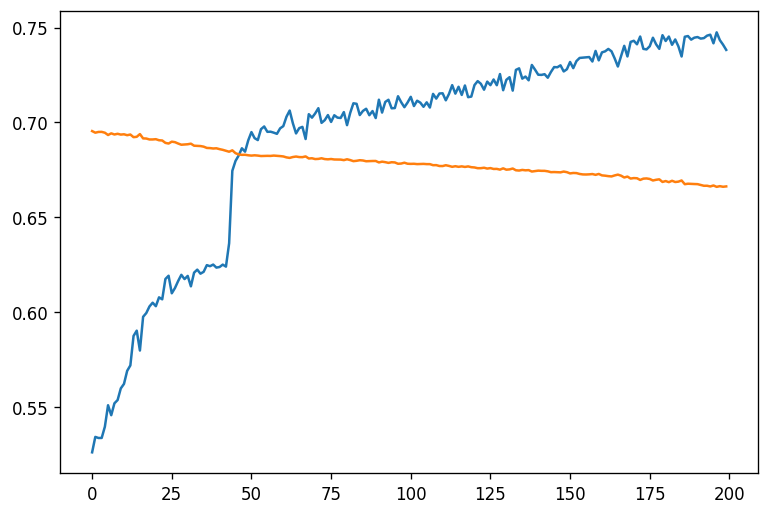

In [19]:
plt.figure(figsize = (7.5, 5), dpi = 120)
plt.plot(fourier_values)
plt.plot(bce_values)

In [20]:
torch.save(model.state_dict(), os.path.join(os.getenv("HOME"), "higgs", "model_fourier.pth"))

In [21]:
model_weights = torch.load(os.path.join(os.getenv("HOME"), "higgs", "model_fourier.pth"), weights_only = True)

In [22]:
model.load_state_dict(model_weights)

<All keys matched successfully>

In [23]:
test_ds = HiggsDataset(test_df)

In [24]:
predictions = []
eval_model = model.eval().cpu()
test_dl = torch.utils.data.DataLoader(dataset = test_ds, batch_size = 250)
for x, _ in tqdm(test_dl):
    xs = x.detach().cpu()
    ys = eval_model.forward(xs).detach().cpu()
    predictions.append(ys)
predictions = torch.vstack(predictions).detach().cpu()

100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:17<00:00, 235.19it/s]


In [25]:
predictions[:10, :]

tensor([[0.4601, 0.5265],
        [0.4877, 0.4988],
        [0.5343, 0.4636],
        [0.5457, 0.4461],
        [0.4893, 0.4962],
        [0.4759, 0.5100],
        [0.5599, 0.4367],
        [0.5251, 0.4634],
        [0.4995, 0.4859],
        [0.4256, 0.5639]])

In [26]:
import sklearn.metrics
import sklearn.preprocessing

In [27]:
import numpy as np

In [28]:
test_onehot = np.zeros(shape = (len(test_df), 2), dtype = np.float32)
test_onehot[~~test_df["label"].to_numpy(), 1] = 1
test_onehot[~test_df["label"].to_numpy(), 0] = 1

In [29]:
predictions_np = predictions.numpy()

In [30]:
for i in range(target_count):
    print(i, sklearn.metrics.roc_auc_score(test_onehot[:, i], predictions_np[:, i]))

0 0.7455374855646043
1 0.7449054517247276


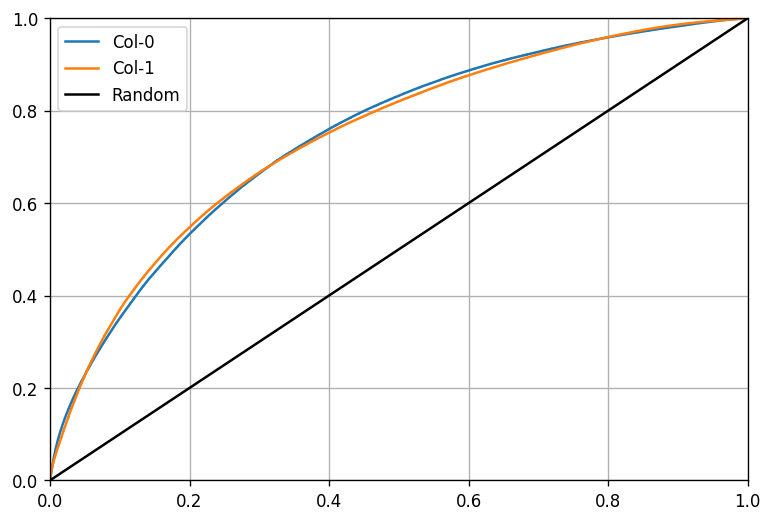

In [31]:
plt.figure(figsize = (7.5, 5), dpi = 120)
for i in range(target_count):
    fpr, tpr, thr = sklearn.metrics.roc_curve(test_onehot[:, i], predictions_np[:, i])
    plt.plot(fpr, tpr, label = f"Col-{i}")
plt.plot([0.0, 1.0], [0.0, 1.0], label = "Random", color = "k")
plt.legend()
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.grid()

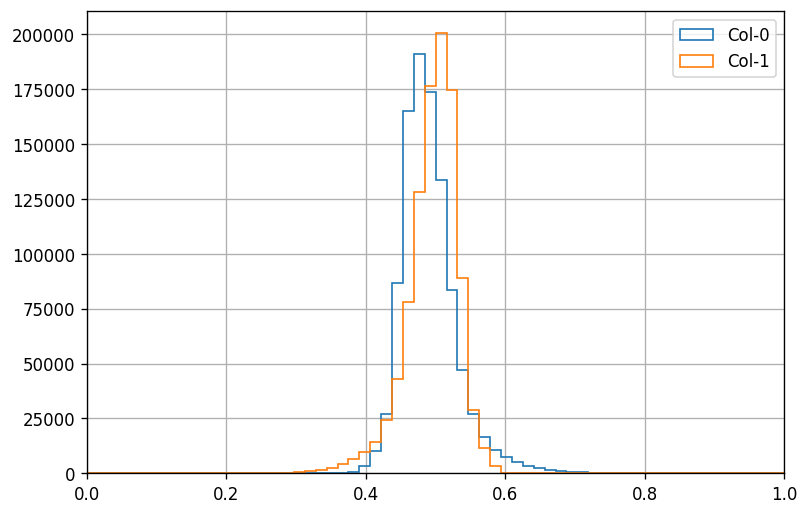

In [32]:
plt.figure(figsize = (7.5, 5), dpi = 120)
for i in range(target_count):
    plt.hist(predictions_np[:, i], bins = 64, range = (0, 1), histtype = "step", label = f"Col-{i}")
plt.legend()
#plt.yscale("log", base = 2)
plt.xlim(0, 1)
plt.grid()

In [33]:
xs = torch.arange(0.0, 1.0, 1e-4, dtype = torch.float32)

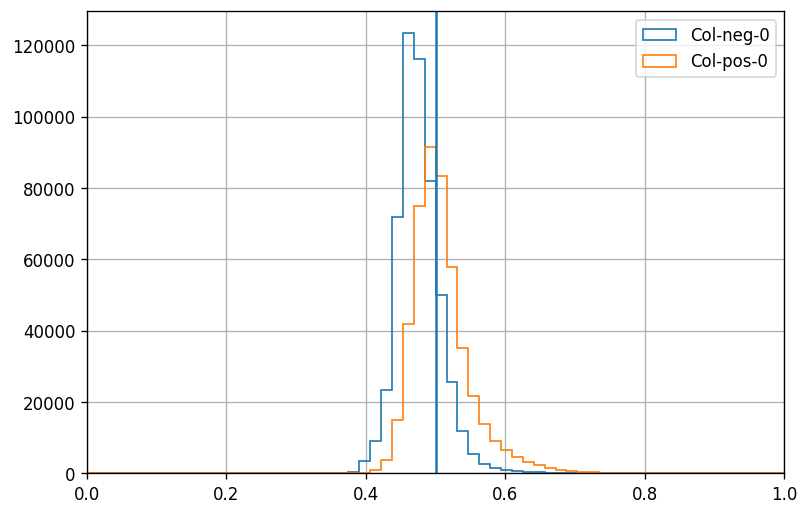

In [34]:
plt.figure(figsize = (7.5, 5), dpi = 120)
for i in range(1):
    plt.hist(predictions_np[:, i][test_onehot[:, i] == 0], bins = 64, range = (0, 1), histtype = "step", label = f"Col-neg-{i}")
    plt.hist(predictions_np[:, i][test_onehot[:, i] == 1], bins = 64, range = (0, 1), histtype = "step", label = f"Col-pos-{i}")
plt.axvline(x = 0.5)
plt.legend()
plt.xlim(0, 1)
plt.grid()

In [35]:
scores_fourier = list()
n_harmonics = 128
predictions_scaled = predictions.detach()

for i in range(target_count):
    fourier = compute_fourier(predictions_scaled[:, i], n_harmonics = n_harmonics)
    scores_fourier.append(fourier)

In [36]:
cdf_fourier = [integrate(fourier) for fourier in scores_fourier]
cdf_fourier = [normalize_by_samples(fourier) for fourier in cdf_fourier]

In [37]:
predictions_eval = list()
for i in range(target_count):
    fourier = normalize_by_samples(scores_fourier[i])
    predictions_eval.append(evaluate_fourier(xs, fourier))

predictions_eval = torch.stack(predictions_eval)

In [38]:
cdf_eval = list()
for i in range(target_count):
    fourier = normalize_by_samples(cdf_fourier[i])
    cdf_eval.append(evaluate_fourier(xs, fourier))

cdf_eval = torch.stack(cdf_eval).numpy()
cdf_eval = (cdf_eval + 0.25) / 1.75

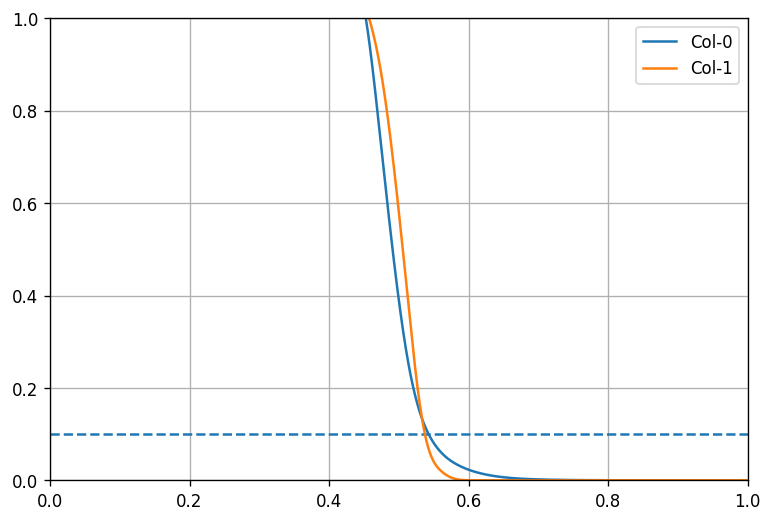

In [39]:
plt.figure(figsize = (7.5, 5), dpi = 120)
plt.axhline(y = 0.1, linestyle = "--")
for i in range(target_count):
    plt.plot(xs.numpy(), 1 - cdf_eval[i, :], label = f"Col-{i}")
plt.legend()
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.grid()

In [40]:
def others_cdf(i):
    result = int(0)
    for j in range(target_count):
        if i != j:
            result = result + cdf_fourier[j]
    return normalize_by_samples(result)

In [41]:
other_cdfs = [others_cdf(i) for i in range(target_count)]

In [42]:
others_eval = list()
for i in range(target_count):
    fourier = normalize_by_samples(other_cdfs[i])
    others_eval.append(evaluate_fourier(xs, fourier))

others_eval = torch.stack(others_eval).numpy()
others_eval = (others_eval + 0.25) / 1.75

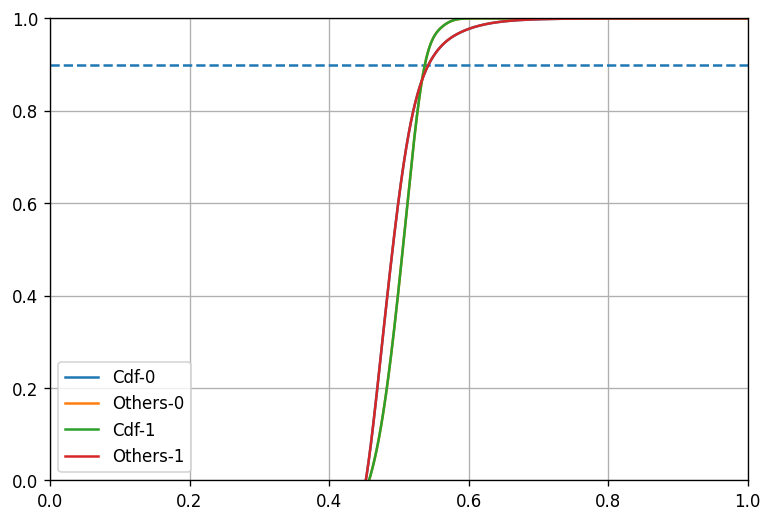

In [43]:
plt.figure(figsize = (7.5, 5), dpi = 120)
plt.axhline(y = 0.9, linestyle = "--")
for i in range(target_count):
    plt.plot(xs.numpy(), cdf_eval[i, :], label = f"Cdf-{i}")
    plt.plot(xs.numpy(), others_eval[i, :], label = f"Others-{i}")
plt.legend()
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.grid()

In [44]:
c0_ind = torch.asarray(test_onehot[:, 0]).to(torch.bool)
c0_pos, c0_neg = torch.nonzero(c0_ind), torch.nonzero(~c0_ind)
c0_pos, c0_neg = c0_pos.squeeze(-1), c0_neg.squeeze(-1)

In [45]:
c0_predictions = predictions[:, 0].detach().squeeze(-1)
c0_pos_scores, c0_neg_scores = c0_predictions[c0_pos], c0_predictions[c0_neg]

In [46]:
c0_pos_fourier, c0_neg_fourier = compute_fourier(c0_pos_scores, n_harmonics), compute_fourier(c0_neg_scores, n_harmonics)
c0_pos_fourier, c0_neg_fourier = normalize_by_samples(c0_pos_fourier), normalize_by_samples(c0_neg_fourier)

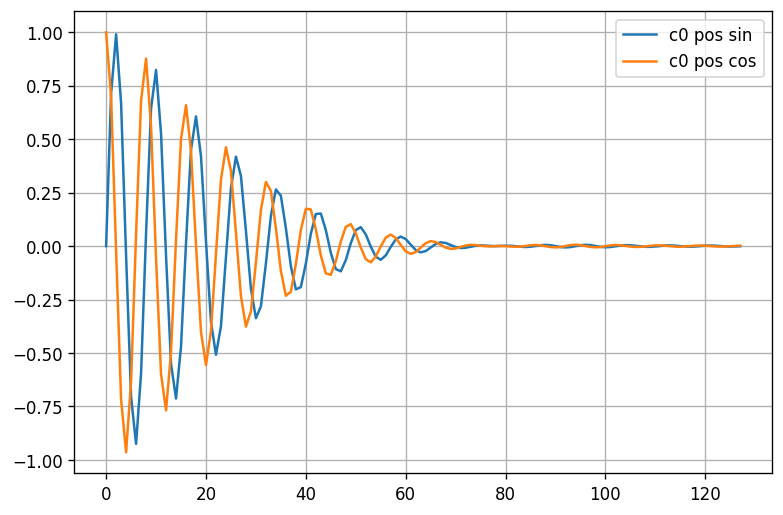

In [47]:
plt.figure(figsize = (7.5, 5), dpi = 120)
plt.plot(c0_pos_fourier.sin.numpy(), label = "c0 pos sin")
plt.plot(c0_pos_fourier.cos.numpy(), label = "c0 pos cos")
plt.legend()
plt.grid()

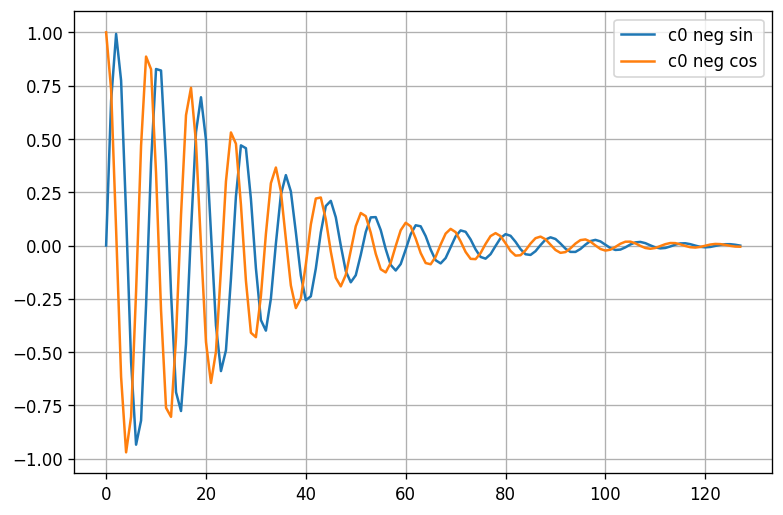

In [48]:
plt.figure(figsize = (7.5, 5), dpi = 120)
plt.plot(c0_neg_fourier.sin.numpy(), label = "c0 neg sin")
plt.plot(c0_neg_fourier.cos.numpy(), label = "c0 neg cos")
plt.legend()
plt.grid()

In [49]:
c0_pos_eval, c0_neg_eval = evaluate_fourier(xs, c0_pos_fourier), evaluate_fourier(xs, c0_neg_fourier)

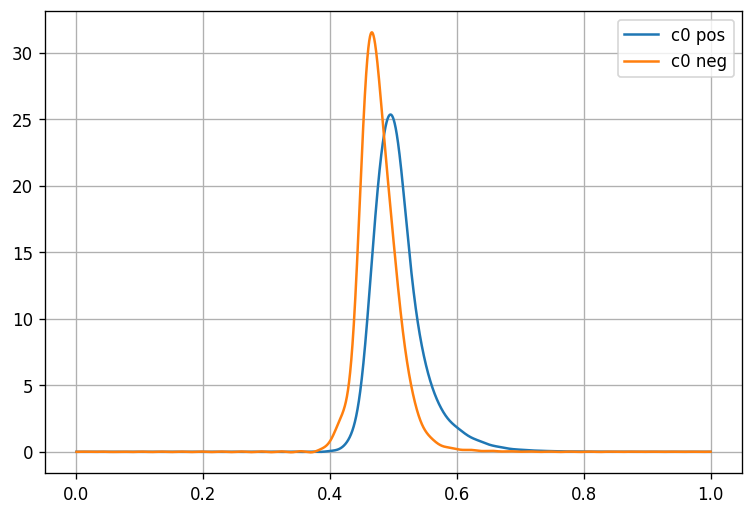

In [50]:
plt.figure(figsize = (7.5, 5), dpi = 120)
plt.plot(xs.numpy(), c0_pos_eval.numpy(), label = "c0 pos")
plt.plot(xs.numpy(), c0_neg_eval.numpy(), label = "c0 neg")
plt.legend()
plt.grid()

In [51]:
c0_pos_cdf, c0_neg_cdf = integrate(c0_pos_fourier), integrate(c0_neg_fourier)
c0_pos_cdf, c0_neg_cdf = normalize_by_samples(c0_pos_cdf), normalize_by_samples(c0_neg_cdf)

In [52]:
c0_pos_cdf_eval, c0_neg_cdf_eval = evaluate_fourier(xs, c0_pos_cdf), evaluate_fourier(xs, c0_neg_cdf)

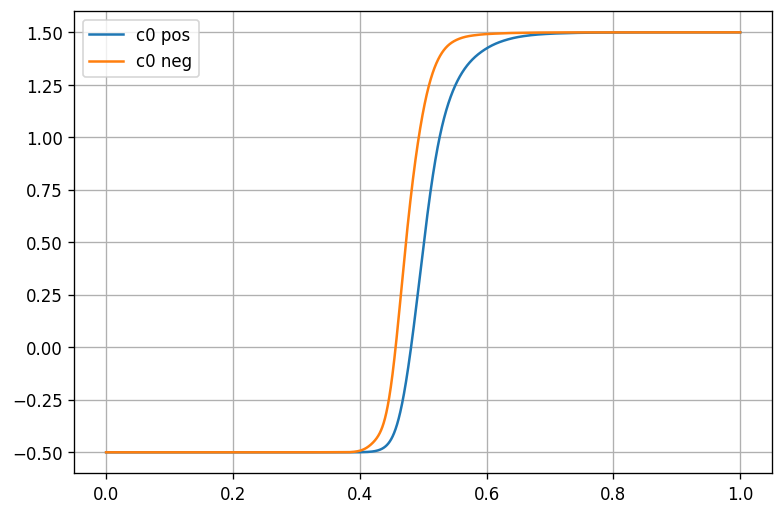

In [53]:
plt.figure(figsize = (7.5, 5), dpi = 120)
plt.plot(xs.numpy(), c0_pos_cdf_eval.numpy(), label = "c0 pos")
plt.plot(xs.numpy(), c0_neg_cdf_eval.numpy(), label = "c0 neg")
plt.legend()
plt.grid()

In [54]:
c0_pos_norm = 1 - (c0_pos_cdf_eval + 0.5) * 0.5
c0_neg_norm = 1 - (c0_neg_cdf_eval + 0.5) * 0.5

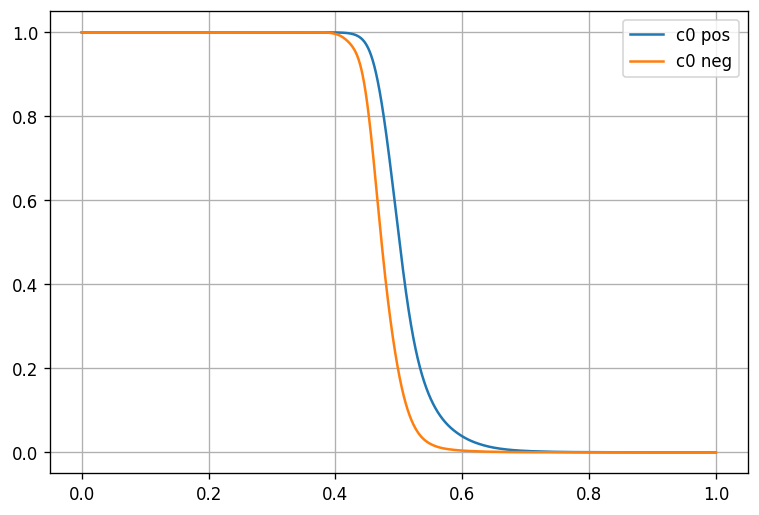

In [55]:
plt.figure(figsize = (7.5, 5), dpi = 120)
plt.plot(xs.numpy(), c0_pos_norm.numpy(), label = "c0 pos")
plt.plot(xs.numpy(), c0_neg_norm.numpy(), label = "c0 neg")
plt.legend()
plt.grid()

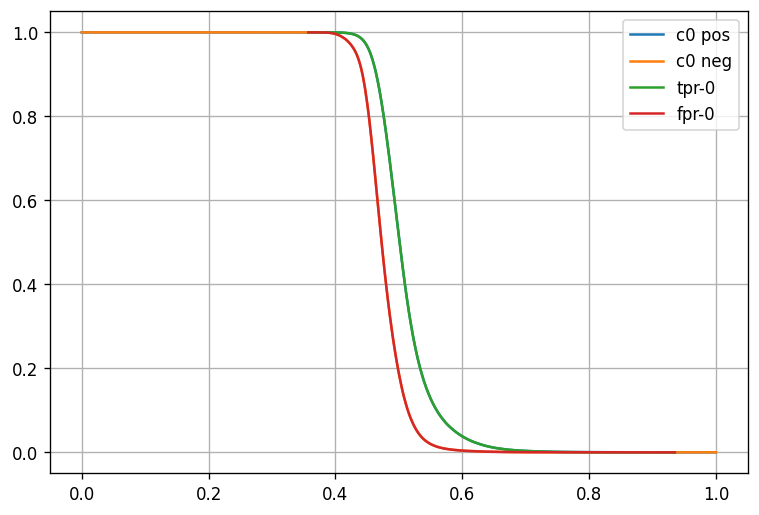

In [56]:
plt.figure(figsize = (7.5, 5), dpi = 120)
plt.plot(xs.numpy(), c0_pos_norm.numpy(), label = "c0 pos")
plt.plot(xs.numpy(), c0_neg_norm.numpy(), label = "c0 neg")

fpr, tpr, thr = sklearn.metrics.roc_curve(test_onehot[:, 0], predictions_np[:, 0])
plt.plot(thr, tpr, label = f"tpr-0")
plt.plot(thr, fpr, label = f"fpr-0")

plt.legend()
plt.grid()

In [57]:
c0_neg_add = np.hstack([[1], c0_neg_norm.numpy(), [0]])
c0_pos_add = np.hstack([[1], c0_pos_norm.numpy(), [0]])

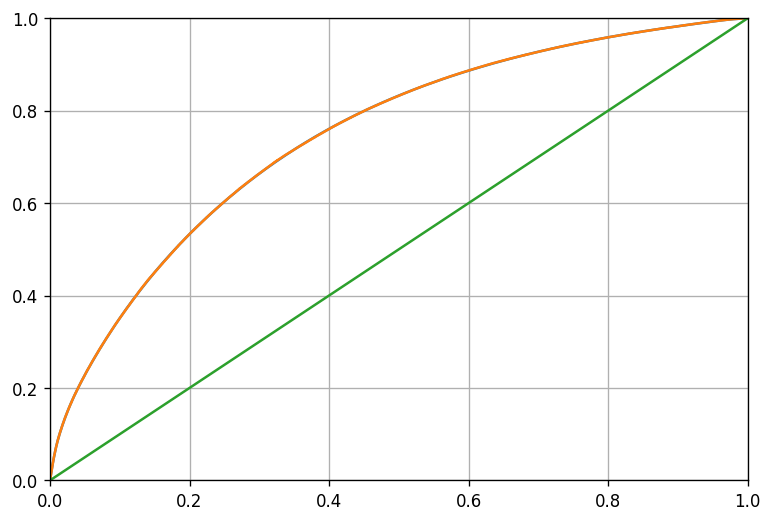

In [58]:
plt.figure(figsize = (7.5, 5), dpi = 120)
plt.plot(c0_neg_add, c0_pos_add)
fpr, tpr, _ = sklearn.metrics.roc_curve(test_onehot[:, 0], predictions_np[:, 0])
plt.plot(fpr, tpr, label = f"tpr-0")
plt.plot([0, 1], [0, 1])
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.grid()

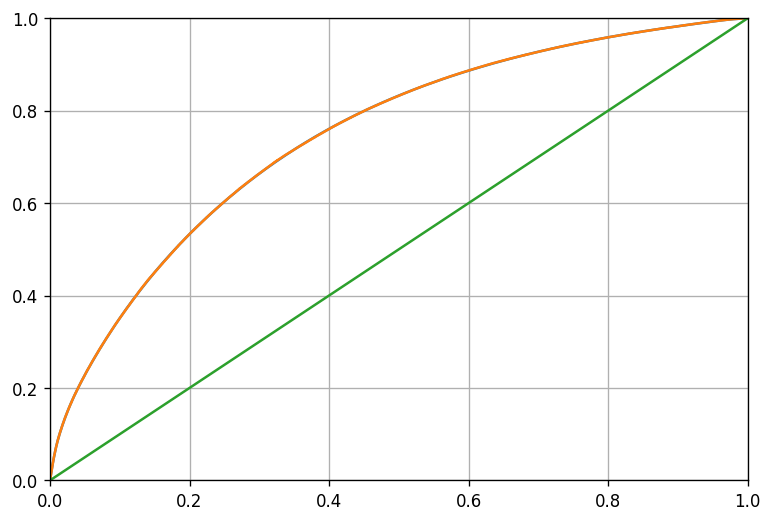

In [59]:
plt.figure(figsize = (7.5, 5), dpi = 120)
plt.plot(c0_neg_add, c0_pos_add)
fpr, tpr, _ = sklearn.metrics.roc_curve(test_onehot[:, 0], predictions_np[:, 0])
plt.plot(fpr, tpr, label = f"tpr-0")
plt.plot([0, 1], [0, 1])
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.grid()

In [60]:
renorm_fpr_diff = -np.diff(c0_neg_add)

roc_auc_renorm = np.sum(c0_pos_add[:-1] * renorm_fpr_diff)
roc_auc_renorm.item()

0.7459102571304541

In [61]:
renorm_tpr_diff = np.diff(c0_pos_add)

roc_auc_renorm = np.sum(c0_neg_add[:-1] * renorm_tpr_diff)
1 + roc_auc_renorm.item()

0.7451644011888092